In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os


import tensorflow as tf

import uproot3


rc('text', usetex=True)

import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

#
mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})
mpl.rcParams.update({'axes.labelsize': 18}) 
mpl.rcParams.update({'legend.frameon': False}) 

import mplhep as hep
hep.set_style(hep.style.ROOT)

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages

In [2]:
#
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
#sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [3]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

In [4]:
def applyCut(inputDataframe, cut, text=None):
    dataframe = inputDataframe
    nbeforecut = dataframe.shape[0]
    cutDataframe = dataframe.query(cut)
    if text:
        print (text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut))
    return cutDataframe

In [5]:
def applyCutsJets(df,isMC=False):
    temp = df
    #temp = applyCut(temp, 'abs(vertex_z)<25 and vertex_z!=0','abs(vertex_z)<25 and and vertex_z!=0')
    #temp = applyCut(temp, 'tau1b>0 and tau1b<1', '0<tau1b<1')
    temp.eval('e_pt = sqrt(e_px*e_px + e_py*e_py)',inplace=True)

    temp.eval('logQ2= log(Q2)/2.3025850', inplace=True)
    temp.eval('track_jetp = sqrt(track_jetpx*track_jetpx + track_jetpy*track_jetpy + track_jetpz*track_jetpz)', inplace=True)
    temp.eval('track_jeteta = arctanh(track_jetpz/track_jetp)',inplace=True)
    temp.eval('track_jetpt = sqrt(track_jetpx*track_jetpx + track_jetpy*track_jetpy)', inplace=True)
    temp.eval('track_jetqt = sqrt( (e_px+track_jetpx)**2 + (e_py+track_jetpy)**2)',inplace=True)
    temp.eval('track_jetqtnorm = track_jetqt/sqrt(Q2)',inplace=True)
    
    temp.eval('track_p=sqrt(track_px*track_px+track_py*track_py + track_pz*track_pz)',inplace=True)
    temp.eval('track_pt=sqrt(track_px*track_px + track_py*track_py)',inplace=True)
    
    temp = applyCut(temp, '0.2 < y < 0.7', '0.2 < y < 0.7')
    temp = applyCut(temp, 'Q2>150', 'Q2>150')
    temp = applyCut(temp, 'pass_reco==0 | track_pt>0.200', 'track pT >200 MeV')
    temp = applyCut(temp, 'pass_reco==0 | track_jetpt>10.0', 'jet pT > 10 GeV')

    
    #temp = applyCut(temp, 'e_pt>15', 'e_pt >15')
    #temp = applyCut(temp, 'jet_pt>10', 'jet_pt>10')
   # temp = applyCut(temp, 'isBKG<1.0', 'isBKG')

    #temp = applyCut(temp, 'jet_qt<5', 'jet_qt<5')

    #temp = applyCut(temp, 'dphi_e_jet > 2.74', 'dphi_e_jet>3.14159-0.4')
    #temp = applyCut(temp, 'pass_reco==0 or track_jetpt >10.0', ' jet pt>10.0')
    
    #temp.eval('dphi = 3.14159-jet_dphi', inplace=True)
    #temp.eval('jet_qtnormjetpt= jet_qt/jet_pt', inplace=True)
    #temp.eval('jet_qtnormept= jet_qt/e_pt', inplace=True)
    if(isMC):
        temp.eval('gen_logQ2= log(gen_Q2)/2.3025850', inplace=True)
        temp.eval('gen_track_jetp = sqrt(gen_track_jetpx*gen_track_jetpx + gen_track_jetpy*gen_track_jetpy + gen_track_jetpz*gen_track_jetpz)', inplace=True)
        temp.eval('gen_track_jeteta = arctanh(gen_track_jetpz/gen_track_jetp)',inplace=True)

        
        temp.eval('gen_track_jetpt = sqrt(gen_track_jetpx*gen_track_jetpx + gen_track_jetpy*gen_track_jetpy)', inplace=True)
        temp.eval('gen_track_jetqt = sqrt( (gene_px+gen_track_jetpx)**2 + (gene_py+gen_track_jetpy)**2)',inplace=True)
        temp.eval('gen_track_jetqtnorm = gen_track_jetqt/sqrt(gen_Q2)',inplace=True)
        temp.eval('gene_pt = sqrt(gene_px*gene_px + gene_py*gene_py)',inplace=True)

        
        temp.eval('gen_track_p=sqrt(gen_track_px*gen_track_px+gen_track_py*gen_track_py + gen_track_pz*gen_track_pz)',inplace=True)
        temp.eval('gen_track_pt=sqrt(gen_track_px*gen_track_px + gen_track_py*gen_track_py)',inplace=True)
        
    #    temp.eval('genjet_qtnormept= genjet_qt/e_pt', inplace=True)
    #    temp.eval('genjet_qtnormjetpt= genjet_qt/genjet_pt', inplace=True)


    #df = applyCut(df, 'n_total>1', ' n>1')
    return temp

## Get dataframes, apply selection

In [6]:
path = '/home/marratia/data/'
dataname = path+'data.root'
mcname = path+'Django.root'
altmcname = path+'Rapgap.root'

In [7]:
datatree = uproot3.open(dataname)['Data/minitree']
altmctree   = uproot3.open(mcname)['Django/minitree']
mctree  = uproot3.open(altmcname)['Rapgap/minitree']

In [8]:
data =  datatree.pandas.df(["track*","Q2","y","e_*"], entrystop=3e5,flatten=True)   # not the default

In [10]:
mc =  mctree.pandas.df(["track*", "gen_track*","Q2","gen_Q2","y",'gen_y',"e_*","gene*"], entrystop=3e5,flatten=True)   # not the default

In [11]:
altmc =  altmctree.pandas.df(["track*", "gen_track*","Q2","gen_Q2","y","gen_y","e_*","gene*"], entrystop=3e5,flatten=True)   # not the default

## Defining pass reco and pass truth variables

In [12]:
mc['pass_reco'] = np.where(mc['track_jt']>0, 1, 0)
mc['pass_truth'] = np.where(mc['gen_track_jt']>0, 1, 0)
altmc['pass_reco'] = np.where(altmc['track_jt']>0, 1, 0)
altmc['pass_truth'] = np.where(altmc['gen_track_jt']>0, 1, 0)
data['pass_reco'] = np.where(data['track_jt']>0, 1, 0)

## Event selection

In [13]:
print('Selecting data events\n')
data = applyCutsJets(data)
print('Selecting MC events\n')
mc   = applyCutsJets(mc, isMC=True)
print('alt mc')
altmc = applyCutsJets(altmc, isMC=True)

Selecting data events

0.2 < y < 0.7 758533  fraction kept: 60.3
Q2>150 644756  fraction kept: 85.0
track pT >200 MeV 570662  fraction kept: 88.5
jet pT > 10 GeV 461298  fraction kept: 80.8
Selecting MC events

0.2 < y < 0.7 1231754  fraction kept: 69.2
Q2>150 1094280  fraction kept: 88.8
track pT >200 MeV 1044328  fraction kept: 95.4
jet pT > 10 GeV 900872  fraction kept: 86.3
alt mc
0.2 < y < 0.7 1209638  fraction kept: 69.8
Q2>150 1047581  fraction kept: 86.6
track pT >200 MeV 1003684  fraction kept: 95.8
jet pT > 10 GeV 869193  fraction kept: 86.6


In [14]:
mc.head()

track_z  track_jt  track_px  track_py  track_pz  \
entry subentry                                                     
1     0         0.023946  0.178918 -0.300700  0.112226  0.216014   
      1         0.017574  0.285831 -0.250029  0.134508 -0.253900   
      2         0.020063  0.060108 -0.281049  0.084592 -0.008102   
      3         0.042289  0.071459 -0.557668  0.247156  0.001359   
      4         0.071493  0.196892 -0.930837  0.464420 -0.073810   

                track_charge  track_jetpx  track_jetpy  track_jetpz  \
entry subentry                                                        
1     0                    1   -12.876843     6.046409     1.680877   
      1                   -1   -12.876843     6.046409     1.680877   
      2                   -1   -12.876843     6.046409     1.680877   
      3                   -1   -12.876843     6.046409     1.680877   
      4                    1   -12.876843     6.046409     1.680877   

                gen_track_z  ...  track_pt  gen_logQ2  gen_track_jetp  \
entry subentry               ...                                        
1     0            0.023127  ...  0.320960   2.192185       15.190356   
      1            0.015025  ...  0.283914   2.192185       15.190356   
      2            0.018748  ...  0.293504   2.192185       15.190356   
      3            0.039986  ...  0.609984   2.192185       15.190356   
      4            0.066410  ...  1.040261   2.192185       15.190356   

                gen_track_jeteta  gen_track_jetpt  gen_track_jetqt  \
entry subentry                                                       
1     0                 0.183892        14.937085         6.082553   
      1                 0.183892        14.937085         6.082553   
      2                 0.183892        14.937085         6.082553   
      3                 0.183892        14.937085         6.082553   
      4                 0.183892        14.937085         6.082553   

                gen_track_jetqtnorm  gene_pt  gen_track_p  gen_track_pt  
entry subentry                                                           
1     0                    0.487521  9.31152     0.378932      0.320846  
      1                    0.487521  9.31152     0.377116      0.279566  
      2                    0.487521  9.31152     0.293994      0.293863  
      3                    0.487521  9.31152     0.617246      0.617240  
      4                    0.487521  9.31152     1.052786      1.046974  

[5 rows x 48 columns]

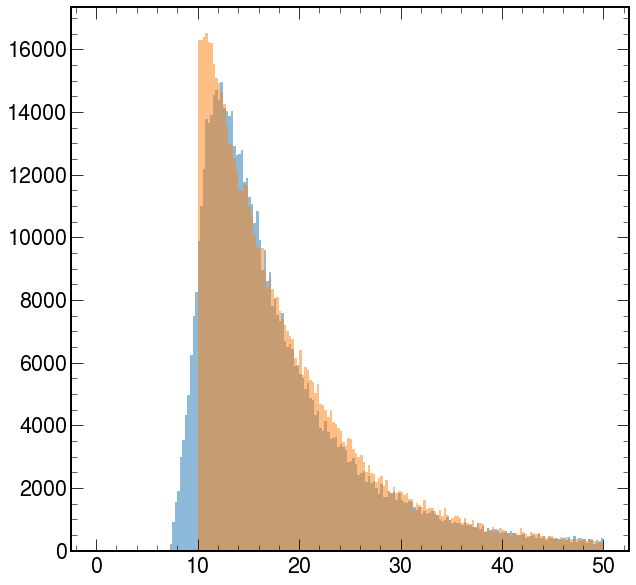

In [15]:
plt.hist(mc.query('pass_reco==1')['e_pt'],range=(0,50),bins=200,alpha=0.5)
plt.hist(mc.query('pass_reco==1')['track_jetpt'],range=(0,50),bins=200,alpha=0.5)

plt.show()

In [16]:
mc_cut = mc[:1000000]
altmc_cut = altmc[:1000000]

In [17]:
print(len(data))
print(len(mc_cut.query('pass_reco==1'))) ##only what is really reconstructed counts
print(len(mc_cut)) ##only what is really reconstructed counts
print(len(altmc_cut.query('pass_reco==1'))) ##only what is really reconstructed counts


461298
675626
900872
650730


### Define UniFold Algorithm


In [18]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Dense, Input
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


## Define features using just MC and alt MC *this is CLOSURE TEST*

In [19]:
epx_0_G       = mc_cut['gene_px']/10.0
epx_0_S       = mc_cut['e_px']/10.0
epx_unknown_G = altmc_cut['gene_px']/10.0
epx_unknown_S = altmc_cut['e_px']/10.0

epy_0_G       = mc_cut['gene_py']/10.0
epy_0_S       = mc_cut['e_py']/10.0
epy_unknown_G = altmc_cut['gene_py']/10.0
epy_unknown_S = altmc_cut['e_py']/10.0

epz_0_G       = mc_cut['gene_pz']/10.0
epz_0_S       = mc_cut['e_pz']/10.0
epz_unknown_G = altmc_cut['gene_pz']/10.0
epz_unknown_S = altmc_cut['e_pz']/10.0


trackpx_0_G       = mc_cut['gen_track_px']/10.0
trackpx_0_S       = mc_cut['track_px']/10.0
trackpx_unknown_G = altmc_cut['gen_track_px']/10.0
trackpx_unknown_S = altmc_cut['track_px']/10.0

trackpy_0_G       = mc_cut['gen_track_py']/10.0
trackpy_0_S       = mc_cut['track_py']/10.0
trackpy_unknown_G = altmc_cut['gen_track_py']/10.0
trackpy_unknown_S = altmc_cut['track_py']/10.0

trackpz_0_G       = mc_cut['gen_track_pz']/10.0
trackpz_0_S       = mc_cut['track_pz']/10.0
trackpz_unknown_G = altmc_cut['gen_track_pz']/10.0
trackpz_unknown_S = altmc_cut['track_pz']/10.0

trackjt_0_G       = mc_cut['gen_track_jt']/10.0
trackjt_0_S       = mc_cut['track_jt']/10.0
trackjt_unknown_G = altmc_cut['gen_track_jt']/10.0
trackjt_unknown_S = altmc_cut['track_jt']/10.0


jetpx_0_G       = mc_cut['gen_track_jetpx']/10.0
jetpx_0_S       = mc_cut['track_jetpx']/10.0
jetpx_unknown_G = altmc_cut['gen_track_jetpx']/10.0
jetpx_unknown_S = altmc_cut['track_jetpx']/10.0


jetpy_0_G       = mc_cut['gen_track_jetpy']/10.0
jetpy_0_S       = mc_cut['track_jetpy']/10.0
jetpy_unknown_G = altmc_cut['gen_track_jetpy']/10.0
jetpy_unknown_S = altmc_cut['track_jetpy']/10.0



jetpz_0_G       = mc_cut['gen_track_jetpz']/10.0
jetpz_0_S       = mc_cut['track_jetpz']/10.0
jetpz_unknown_G = altmc_cut['gen_track_jetpz']/10.0
jetpz_unknown_S = altmc_cut['track_jetpz']/10.0


In [20]:
theta0_G=np.c_[(epx_0_G, epy_0_G, epz_0_G,  trackjt_0_G, jetpx_0_G, jetpy_0_G, jetpz_0_G)]
theta0_S=np.c_[(epx_0_S, epy_0_S, epz_0_S,  trackjt_0_S, jetpx_0_S, jetpy_0_S, jetpz_0_S)]
theta_unknown_G =np.c_[(epx_unknown_G, epy_unknown_G, epz_unknown_G, trackjt_unknown_G, jetpx_unknown_G, jetpy_unknown_G, jetpz_unknown_G)]
theta_unknown_S =np.c_[(epx_unknown_S, epy_unknown_S, epz_unknown_S, trackjt_unknown_S, jetpx_unknown_S, jetpy_unknown_S, jetpz_unknown_S)]


In [22]:
theta0_G=np.c_[(epx_0_G, epy_0_G, epz_0_G, trackpx_0_G, trackpy_0_G, trackpz_0_G, jetpx_0_G, jetpy_0_G, jetpz_0_G)]
theta0_S=np.c_[(epx_0_S, epy_0_S, epz_0_S, trackpx_0_S, trackpy_0_S, trackpz_0_S, jetpx_0_S, jetpy_0_S, jetpz_0_S)]
theta_unknown_G =np.c_[(epx_unknown_G, epy_unknown_G, epz_unknown_G, trackpx_unknown_G, trackpy_unknown_G, trackpz_unknown_G, jetpx_unknown_G, jetpy_unknown_G, jetpz_unknown_G)]
theta_unknown_S =np.c_[(epx_unknown_S, epy_unknown_S, epz_unknown_S, trackpx_unknown_S, trackpy_unknown_S, trackpz_unknown_S, jetpx_unknown_S, jetpy_unknown_S, jetpz_unknown_S)]



In [23]:
pass_reco = np.array(mc_cut['pass_reco'])
pass_truth = np.array(mc_cut['pass_truth'])
theta0_S[:,0][pass_reco==0] = -10
theta0_G[:,0][pass_truth==0] = -10

## Show input for closure test (i.e. synthetic and natural datasets using mc and altmc)

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


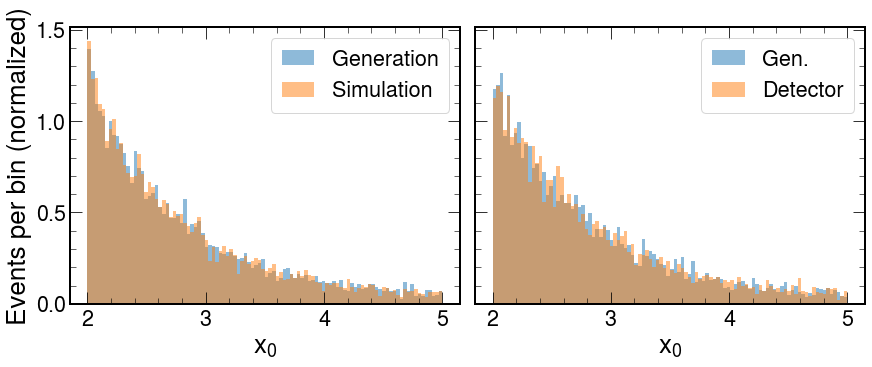

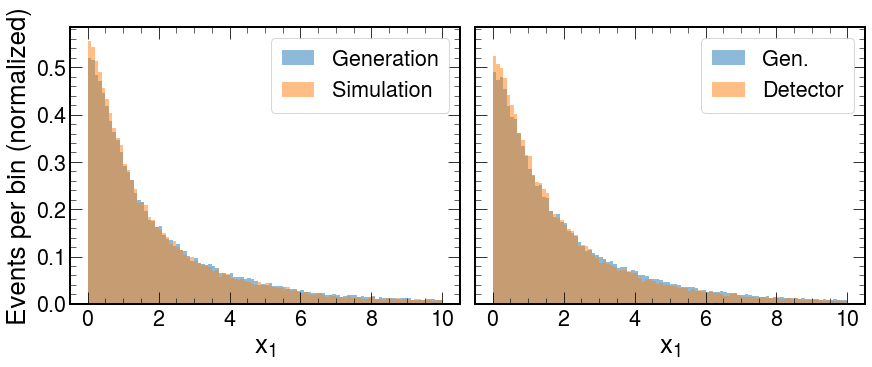

In [24]:
bins = np.linspace(2,5, 101)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x_0$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G[theta0_G[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Simulation')
legend = ax[0].legend(
    loc='best',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x_0$')

ax[1].hist(theta_unknown_G[theta_unknown_S[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Gen.')
legend = ax[1].legend(
    loc='best',
    frameon=True)


ax[1].hist(theta_unknown_S[theta_unknown_S[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Detector')
legend = ax[1].legend(
    loc='best',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

bins = np.linspace(0,10, 101)
#bins = np.linspace(0,2, 101)
#bins = np.linspace(0,1,100)
fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G[theta0_G[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Simulation')
legend = ax[0].legend(
    loc='best',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x_1$')

ax[1].hist(theta_unknown_G[theta_unknown_S[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Gen.')
legend = ax[1].legend(
    loc='best',
    frameon=True)

ax[1].hist(theta_unknown_S[theta_unknown_S[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Detector')
legend = ax[1].legend(
    loc='best',
    frameon=True)






plt.setp(legend.get_title(), multialignment='center')

fig.show()

## Define Multifold 

In [25]:
# Input multiple observables as tuple or list (i.e. theta0_G = (obs_1, obs_2, ...))
"""    Arguments:
        num_observables: number of observables to 
                            simultaneously unfold (integer)
                            
        iterations: number of iterations (integer)
        
        theta0_G: tuple or list of nominal 
                    generation-level observables as Numpy arrays
                    
        theta0_S: tuple or list of nominal 
                    simulation-level observables as Numpy arrays
                    
        theta_unknown_S: tuple or list of "natural" 
                            (unknown) simulation-level observables 
                            to be unfolded as Numpy arrays
        
        Returns:
        - A Numpy array of weights to reweight distributions in 
        theta0_G to the unfolded distribution of theta_unknown_S
        
        - The model used to calculate those weights
"""


def multifold(num_observables, iterations, theta0_G, theta0_S,
              theta_unknown_S):
    
    
    theta0 = np.stack([theta0_G, theta0_S], axis=1)
    labels0 = np.zeros(len(theta0))
    theta_unknown = np.stack([theta_unknown_S, theta_unknown_S], axis=1)
    labels1 = np.ones(len(theta0_G))
    labels_unknown = np.ones(len(theta_unknown_S))
    
    xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels0, labels_unknown))
    xvals_2 = np.concatenate((theta0_G, theta0_G))
    yvals_2 = np.concatenate((labels0, labels1))
    

    weights = np.empty(shape=(iterations, 2, len(theta0_G))) #this was 0
    weights_pull = np.ones(len(theta0_S))
    weights_push = np.ones(len(theta0_S))

    inputs = Input((num_observables, ))
     #inputs = Input((2, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

    model = Model(inputs=inputs, outputs=outputs)

    earlystopping = EarlyStopping(patience=10,
                              verbose=1,
                              restore_best_weights=True)
    # from NN (DCTR) 
    def reweight(events):
        f = model.predict(events, batch_size=10000)
        weights = f / (1. - f)
        return np.squeeze(np.nan_to_num(weights))
    
    
    
    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
        # weights reweighted Sim. --> Data
        print("STEP 1\n")

        weights_1 = np.concatenate((weights_push, np.ones(len(theta_unknown_S))))
        # actual weights for Sim., ones for Data (not MC weights)

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        #theta0_G[theta0_S[:,0]!=-10][:,1]
        model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
        model.fit(X_train_1[X_train_1[:,0]!=-10],
              Y_train_1[X_train_1[:,0]!=-10],
              sample_weight=w_train_1[X_train_1[:,0]!=-10],
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_1[X_test_1[:,0]!=-10], Y_test_1[X_test_1[:,0]!=-10], w_test_1[X_test_1[:,0]!=-10]),
              callbacks=[earlystopping],
              verbose=1)

        weights_pull = weights_push * reweight(theta0_S)
        weights_pull[theta0_S[:,0]==-10] = 1. #these are events that don't pass reco; take the prior.
        weights[i, :1, :] = weights_pull

        # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
        # weights Gen. --> reweighted Gen.
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
        # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
        model.fit(X_train_2,
              Y_train_2,
              sample_weight=w_train_2,
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_2, Y_test_2, w_test_2),
              callbacks=[earlystopping],
              verbose=1)

        weights_push = reweight(theta0_G)
        weights[i, 1:2, :] = weights_push
    return weights, model

## Unfold two variables simultaneously

In [26]:
K.clear_session()

In [28]:
iterations = 4# use ~4 iterations
num_observables= 9

weights, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=theta0_G,
                       theta0_S=theta0_S,
                       theta_unknown_S= theta_unknown_S)


ITERATION: 1

STEP 1

Train on 1158352 samples, validate on 386467 samples
Epoch 1/200


InternalError: failed initializing StreamExecutor for CUDA device ordinal 0: Internal: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 11719409664

## Put weights into MC dataframe

In [ ]:
mc_cut['weight_reco'] = weights[-1, 0, :]
mc_cut['weight_truth'] = weights[-1, 1, :]

## Check that weights are reasonable

In [ ]:
plt.hist(np.log(mc_cut['weight_truth']),bins=100,**plot_style_2,label='Weight truth')
plt.hist(np.log(mc_cut['weight_reco']),bins=100,**plot_style_2, label='Weight reco')
plt.legend()
plt.xlabel('Log 10 weight truth')
plt.yscale('log')
plt.show()

for i in range(len(weights)):
    print(max(weights[i, 1, :]))
    print(min(weights[i, 1, :]))
    print(max(weights[i, 0, :]))
    print(min(weights[i, 0, :]))
    print(' ')

## Closure Test

In [ ]:
event_selection = 'gen_y>0.2 and gen_y<0.7 and gen_Q2>150'
track_selection = 'gen_track_pt>0.2'
jet_selection    = 'gen_track_jetpt>10'
query = 'pass_reco==1 and ' + event_selection + ' and ' + track_selection + ' and ' + jet_selection
print('The query is:' , query)

label1 = r'Django truth'
label2 = r'Rapgap unfold.'
label3 = r'Rapgap truth'


for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2, 5,100 )
    #bins = np.linspace(5, 50, 45)

    fig, ax = plt.subplots(2,
                           4,
                           figsize=(20, 10),
                           constrained_layout=True)
    bins = np.linspace(0.0, 1.0,25 )

    ax[0,0].set_xlabel(r'$y$',fontsize=22)
    ax[0,0].set_ylabel('Events per bin (Normalized)')
    ax[0,0].hist(mc_cut.query(query)['gen_y'], bins=bins, label=label1, **plot_style_2)
    ax[0,0].hist(mc_cut.query(query)['gen_y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,0].hist(altmc_cut.query(query)['gen_y'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[0,0].legend(frameon=False)

    bins = np.linspace(2, 5,50 )

    ax[0,1].set_xlabel(r'$\log Q^{2}$',fontsize=22)
    ax[0,1].set_ylabel('Events per bin (Normalized)')
    ax[0,1].hist(mc_cut.query(query)['gen_logQ2'], bins=bins, label=label1, **plot_style_2)
    ax[0,1].hist(mc_cut.query(query)['gen_logQ2'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,1].hist(altmc_cut.query(query)['gen_logQ2'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[0,1].legend(frameon=False)

    
    bins = np.logspace(np.log10(0.05),0,25 )

    ax[0,2].set_xlabel(r'$z_{jet} $',fontsize=22)
    ax[0,2].set_ylabel('Events per bin (Normalized)')
    ax[0,2].hist(mc_cut.query(query)['gen_track_z'], bins=bins, label=label1, **plot_style_2)
    ax[0,2].hist(mc_cut.query(query)['gen_track_z'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,2].hist(altmc_cut.query(query)['gen_track_z'],
               bins=bins,
               label=label3,
               **plot_style_2)
    #ax[0,2].set_yscale('log')
    ax[0,2].set_xscale('log')

    ax[0,2].legend(frameon=False)

    bins = np.linspace(0,3,50 )

    ax[1,0].set_xlabel(r'$j_{T} $',fontsize=22)
    ax[1,0].set_ylabel('Events per bin (Normalized)')
    ax[1,0].hist(mc_cut.query(query)['gen_track_jt'], bins=bins, label=label1, **plot_style_2)
    ax[1,0].hist(mc_cut.query(query)['gen_track_jt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[1,0].hist(altmc_cut.query(query)['gen_track_jt'],
               bins=bins,
               label=label3,
               **plot_style_2)
    #ax[1,0].set_yscale('log')
    ax[1,0].legend(frameon=False)

    bins = np.linspace(0,50,50 )

    ax[1,1].set_xlabel(r'$jet p_{T} $',fontsize=22)
    ax[1,1].set_ylabel('Events per bin (Normalized)')
    ax[1,1].hist(mc_cut.query(query)['gen_track_jetpt'], bins=bins, label=label1, **plot_style_2)
    ax[1,1].hist(mc_cut.query(query)['gen_track_jetpt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[1,1].hist(altmc_cut.query(query)['gen_track_jetpt'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[1,1].legend(frameon=False)

    bins = np.linspace(0,2,20 )

    
    ax[1,2].set_xlabel(r'$jet q_{T}/Q $',fontsize=22)
    ax[1,2].set_ylabel('Events per bin (Normalized)')
    ax[1,2].hist(mc_cut.query(query)['gen_track_jetqtnorm'], bins=bins, label=label1, **plot_style_2)
    ax[1,2].hist(mc_cut.query(query)['gen_track_jetqtnorm'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[1,2].hist(altmc_cut.query(query)['gen_track_jetqtnorm'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    
    
    ax[1,2].set_yscale('log')
    ax[1,2].legend(frameon=False)

    bins = np.linspace(-1.5,3,25 )

    ax[0,3].set_xlabel(r'$jet eta $',fontsize=22)
    ax[0,3].set_ylabel('Events per bin (Normalized)')
    ax[0,3].hist(mc_cut.query(query)['gen_track_jeteta'], bins=bins, label=label1, **plot_style_2)
    ax[0,3].hist(mc_cut.query(query)['gen_track_jeteta'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,3].hist(altmc_cut.query(query)['gen_track_jeteta'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[0,3].legend(frameon=False)

    bins = np.linspace(0,100,25)

    ax[1,3].set_xlabel(r'$electron p_{T} $',fontsize=22)
    ax[1,3].set_ylabel('Events per bin (Normalized)')
    ax[1,3].hist(mc_cut.query(query)['gene_pt'], bins=bins, label=label1, **plot_style_2)
    ax[1,3].hist(mc_cut.query(query)['gene_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[1,3].hist(altmc_cut.query(query)['gene_pt'],
               bins=bins,
               label=label3,
               **plot_style_2)
    ax[1,3].legend(frameon=False)

    fig.savefig('figures/Closure_HadronInJet_%i_iter.png'%i)    

## Plot CLOSURE TEST RESULTS, part II

In [ ]:
print('The query is:' , query)


for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2, 5,100 )
    #bins = np.linspace(5, 50, 45)

    fig, ax = plt.subplots(2,
                           3,
                           figsize=(20, 10),
                           constrained_layout=True)
    bins = np.linspace(-20.0, 20.0,100 )

    ax[0,0].set_xlabel('track $p_x$',fontsize=22)
    ax[0,0].set_ylabel('Events per bin (Normalized)')
    ax[0,0].hist(mc_cut.query(query)['gen_track_px'], bins=bins, label=label1, **plot_style_2)
    ax[0,0].hist(mc_cut.query(query)['gen_track_px'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,0].hist(altmc_cut.query(query)['gen_track_px'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[0,0].legend(frameon=False,loc='best')
    
    
    bins = np.linspace(-20.0, 20.0,100 )

    ax[0,1].set_xlabel('track $p_y$',fontsize=22)
    ax[0,1].set_ylabel('Events per bin (Normalized)')
    ax[0,1].hist(mc_cut.query(query)['gen_track_py'], bins=bins, label=label1, **plot_style_2)
    ax[0,1].hist(mc_cut.query(query)['gen_track_py'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,1].hist(altmc_cut.query(query)['gen_track_py'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[0,1].legend(frameon=False,loc='best')
    
    
    bins = np.linspace(-20.0, 60.0,100 )

    ax[0,2].set_xlabel('track $p_z$',fontsize=22)
    ax[0,2].set_ylabel('Events per bin (Normalized)')
    ax[0,2].hist(mc_cut.query(query)['gen_track_pz'], bins=bins, label=label1, **plot_style_2)
    ax[0,2].hist(mc_cut.query(query)['gen_track_pz'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,2].hist(altmc_cut.query(query)['gen_track_pz'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[0,2].legend(frameon=False,loc='best')
    
    
    bins = np.linspace(0, 10,50 )

    ax[1,0].set_xlabel('track $p$',fontsize=22)
    ax[1,0].set_ylabel('Events per bin (Normalized)')
    ax[1,0].hist(mc_cut.query(query)['gen_track_p'], bins=bins, label=label1, **plot_style_2)
    ax[1,0].hist(mc_cut.query(query)['gen_track_p'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[1,0].hist(altmc_cut.query(query)['gen_track_p'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[1,0].legend(frameon=False,loc='best')
    
    bins = np.linspace(0.0, 10.0,50 )

    

    ax[1,1].set_xlabel('track $p_{T}$',fontsize=22)
    ax[1,1].set_ylabel('Events per bin (Normalized)')
    ax[1,1].hist(mc_cut.query(query)['gen_track_pt'],bins=bins, label=label1, **plot_style_2)
    ax[1,1].hist(mc_cut.query(query)['gen_track_pt'],
               bins=bins,
               weights = mc_cut.query(query)['weight_truth'] ,
               label=label2,
               **plot_style_1)

    ax[1,1].hist(altmc_cut.query(query)['gen_track_pt'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[1,1].legend(frameon=False,loc='best')
    
    
   
    
    
    
    ax[0,0].set_yscale('log')
    ax[0,1].set_yscale('log')
    ax[0,2].set_yscale('log')

    plt.tight_layout()
    fig.savefig('figures/Closure_2_HadronInJet_%i_iter.png'%i)  

## Show the reweighting of the reco

In [ ]:
query = 'pass_reco==1 '
print('The query is:' , query)
label1 = r'Django reco'
label2 = r'Django wgt.'
label3 = r'Rapgap reco'

color1='blueviolet'
color2='limegreen'
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2, 5,100 )
    fig, ax = plt.subplots(2,
                           4,
                           figsize=(20, 10),
                           constrained_layout=True)
    bins = np.linspace(0.0, 1.0,25 )

    ax[0,0].set_xlabel(r'$y$',fontsize=22)
    ax[0,0].set_ylabel('Events per bin (Normalized)')
    ax[0,0].hist(mc_cut.query(query)['y'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0,0].hist(mc_cut.query(query)['y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0,0].hist(altmc_cut.query(query)['y'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[0,0].legend(frameon=False,loc='best')

    bins = np.linspace(2, 4,25 )

    ax[0,1].set_xlabel(r'$\log Q^{2}$',fontsize=22)
    ax[0,1].set_ylabel('Events per bin (Normalized)')
    ax[0,1].hist(mc_cut.query(query)['logQ2'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0,1].hist(mc_cut.query(query)['logQ2'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0,1].hist(altmc_cut.query(query)['logQ2'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[0,1].legend(frameon=False,loc='best')

    
    bins = np.logspace(np.log10(0.05),0,25 )

    ax[0,2].set_xlabel(r'$z_{jet} $',fontsize=22)
    ax[0,2].set_ylabel('Events per bin (Normalized)')
    ax[0,2].hist(mc_cut.query(query)['track_z'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0,2].hist(mc_cut.query(query)['track_z'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0,2].hist(altmc_cut.query(query)['track_z'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    #ax[0,2].set_yscale('log')
    ax[0,2].set_xscale('log')
    ax[0,2].legend(frameon=False,loc='best')

    
    bins = np.linspace(0,2.5,50 )

    ax[1,0].set_xlabel(r'$j_{T} $',fontsize=22)
    ax[1,0].set_ylabel('Events per bin (Normalized)')
    ax[1,0].hist(mc_cut.query(query)['track_jt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[1,0].hist(mc_cut.query(query)['track_jt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[1,0].hist(altmc_cut.query(query)['track_jt'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    ax[1,0].legend(frameon=False,loc='best')
    
    bins = np.linspace(0,50,50 )

    ax[1,1].set_xlabel(r'$jet p_{T} $',fontsize=22)
    ax[1,1].set_ylabel('Events per bin (Normalized)')
    ax[1,1].hist(mc_cut.query(query)['track_jetpt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[1,1].hist(mc_cut.query(query)['track_jetpt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[1,1].hist(altmc_cut.query(query)['track_jetpt'],
               bins=bins,
               label=label3,
               **plot_style_2, color=color2)
    ax[1,1].legend(frameon=False,loc='best')

    bins = np.linspace(0,2,20 )

    
    ax[1,2].set_xlabel(r'$jet q_{T}/Q $',fontsize=22)
    ax[1,2].set_ylabel('Events per bin (Normalized)')
    ax[1,2].hist(mc_cut.query(query)['track_jetqtnorm'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[1,2].hist(mc_cut.query(query)['track_jetqtnorm'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[1,2].hist(altmc_cut.query(query)['track_jetqtnorm'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[1,2].legend(frameon=False,loc='best')
    ax[1,2].set_yscale('log')

    bins = np.linspace(-1.5,3,25 )

    ax[0,3].set_xlabel(r'$jet eta $',fontsize=22)
    ax[0,3].set_ylabel('Events per bin (Normalized)')
    ax[0,3].hist(mc_cut.query(query)['track_jeteta'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0,3].hist(mc_cut.query(query)['track_jeteta'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0,3].hist(altmc_cut.query(query)['track_jeteta'],
               bins=bins,
               label=label3,
               **plot_style_2, color=color2)
    
    ax[0,3].legend(frameon=False,loc='best')

    bins = np.linspace(0,100,25)

    ax[1,3].set_xlabel(r'$electron p_{T} $',fontsize=22)
    ax[1,3].set_ylabel('Events per bin (Normalized)')
    ax[1,3].hist(mc_cut.query(query)['e_pt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[1,3].hist(mc_cut.query(query)['e_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[1,3].hist(altmc_cut.query(query)['e_pt'],
               bins=bins,
               label=label3,
               **plot_style_2, color=color2)
    
    ax[1,3].legend(frameon=False,loc='best')
    
    plt.tight_layout()
    fig.savefig('figures/Closure_3_HadronInJet_%i_iter.png'%i)  
    
    

## Closure for differential plots

In [ ]:
#bins = np.logspace(np.log10(0.01),np.log10(3),8)
bins = np.linspace(0,3,20)

fig, axs = plt.subplots(1, 3,sharey=True, figsize=(20,6), gridspec_kw={'wspace':0, 'hspace':0})

for counter,edges in enumerate([(150,500), (500,1000),(1000,10000)]):
    cut = ' gen_Q2 > %2.2f and gen_Q2 <%2.2f and gen_y>0.2 and gen_y<0.7'%(edges[0],edges[1])
    cut = cut + ' and gen_track_jetpt>10 and gen_track_z>0.2'
    #cut = cut + ' and pass_reco==1'
    print (cut)
    #df_cut = df.query(cut)
    #printSummary(df_cut)
    print ('###########')
    axs[counter].xaxis.set_label_text('track $j_{T}$', fontsize=25)
    axs[counter].xaxis.set_label_text('track $j_{T}$', fontsize=25)

    ##Plot data
    #Nelectrons = df.query(cut).shape[0]
   # axs[counter].hist(mc_cut.query(cut+'and pass_reco==1')['track_jt'],weights=mc_cut.query(cut+'and pass_reco==1')['weight_reco'],bins=bins,alpha=0.9,density=True, 
   #                  label='MC wgt to data reco',color='blue',lw=3,histtype='step')

    #axs[counter].hist(mc_cut.query(cut+'and pass_reco==1')['gen_track_jt'],bins=bins,weights=mc_cut.query(cut+'and pass_reco==1')['weight_truth'],label = 'Unfolded',**plot_style_2)
    axs[counter].hist(mc_cut.query(cut)['gen_track_jt'],bins=bins,label='Djangoh Truth',**plot_style_2)
    axs[counter].hist(altmc_cut.query(cut)['gen_track_jt'],bins=bins,label='Rapgap Truth',**plot_style_2)
    axs[counter].hist(mc_cut.query(cut)['gen_track_jt'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Rapgap unfold',**plot_style_1)

    axs[counter].legend(prop={'size': 18}, frameon=False, loc='best')
    axs[counter].set_title(' $ %2.0f< Q^{2} < %2.0f$'%(edges[0],edges[1]))


    #axs[counter].text(1.5,2.9,  r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(data_cut.query(cut)['x'].mean(), data_cut.query(cut)['Q2'].mean()), fontsize=18)
    #axs[counter].set_yscale('log')
    #axs[counter].set_xscale('log')

 
axs[0].yaxis.set_label_text('Normalized entries', fontsize=25)


## check weights

In [ ]:
plt.hist(np.log(mc_cut['weight_truth']),bins=100,**plot_style_2,label='Weight truth')
plt.hist(np.log(mc_cut['weight_reco']),bins=100,**plot_style_2, label='Weight reco')
plt.legend()
plt.xlabel('Log 10 weight truth')
plt.yscale('log')
plt.show()

for i in range(len(weights)):
    print(max(weights[i, 1, :]))
    print(min(weights[i, 1, :]))
    print(max(weights[i, 0, :]))
    print(min(weights[i, 0, :]))
    print(' ')

## Compute some efficiency

In [ ]:
bins = np.logspace(-2,1.5,100)
num,x,_  = plt.hist(mc_cut.query('pass_reco==1')['gen_track_p'], weights=mc_cut.query('pass_reco==1')['weight_truth'],bins=bins,label='numerator, weighted',alpha=0.3)
den,x,_  = plt.hist(mc_cut['gen_track_p'], weights=mc_cut['weight_truth'],bins=bins,label='denominator, weighted',alpha=0.3)
x= (x[1:] + x[:-1])/2.0

plt.legend()
plt.show()
eff_weighted= np.true_divide(num,den)

In [ ]:
plt.plot(x,eff_weighted)

In [ ]:
#bins = np.logspace(np.log10(0.01),np.log10(3),20)
bins = np.linspace(0,3,20)

fig, axs = plt.subplots(1, 3,sharey=True, figsize=(20,6), gridspec_kw={'wspace':0, 'hspace':0})

for counter,edges in enumerate([(150,500), (500,1000),(1000,10000)]):
    cut = ' gen_Q2 > %2.2f and gen_Q2 <%2.2f'%(edges[0],edges[1])
    cut = cut + ' and gen_track_jetpt>15 and gen_track_jetqtnorm<0.3 and gen_track_z>0.2'
    #cut = cut + ' and pass_reco==1'
    print (cut)
    #df_cut = df.query(cut)
    #printSummary(df_cut)
    print ('###########')
    axs[counter].xaxis.set_label_text('jet $p_{T}$', fontsize=25)
    axs[counter].xaxis.set_label_text('jet $p_{T}$', fontsize=25)

    ##Plot data
    #Nelectrons = df.query(cut).shape[0]
    #axs[counter].hist(mc_cut.query(cut+'and pass_reco==1')['track_jt'],weights=mc_cut.query(cut+'and pass_reco==1')['weight_reco'],bins=bins,alpha=0.9,density=True, 
    #                  label='MC wgt to data reco',color='black',lw=3,histtype='step')

    #axs[counter].hist(mc_cut.query(cut+'and pass_reco==1')['gen_track_jt'],bins=bins,weights=mc_cut.query(cut+'and pass_reco==1')['weight_truth'],label = 'Unfolded',**plot_style_2)
    axs[counter].hist(mc_cut.query(cut)['gen_track_jt'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Unfold + eff',**plot_style_2)
    axs[counter].hist(mc_cut.query(cut)['gen_track_jt'],bins=bins,label='MC true',histtype='step',density=True, color='green',lw=2)

    axs[counter].legend(prop={'size': 18}, frameon=False, loc='best')
    axs[counter].set_title(' $ %2.0f< Q^{2} < %2.0f$'%(edges[0],edges[1]))


    #axs[counter].text(1.5,2.9,  r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(data_cut.query(cut)['x'].mean(), data_cut.query(cut)['Q2'].mean()), fontsize=18)
    #axs[counter].set_yscale('log')
    
axs[0].yaxis.set_label_text('Normalized entries', fontsize=25)


In [ ]:
K.clear_session()

## Define features with data

In [ ]:
data_cut = data[:300000]
print(len(mc_cut))
print(len(data_cut))

In [ ]:
epx_0_G       = mc_cut['gene_px']/10.0
epx_0_S       = mc_cut['e_px']/10.0
epx_unknown_S = data_cut['e_px']/10.0

epy_0_G       = mc_cut['gene_py']/10.0
epy_0_S       = mc_cut['e_py']/10.0
epy_unknown_S = data_cut['e_py']/10.0

epz_0_G       = mc_cut['gene_pz']/10.0
epz_0_S       = mc_cut['e_pz']/10.0
epz_unknown_S = data_cut['e_pz']/10.0

trackpx_0_G       = mc_cut['gen_track_px']
trackpx_0_S       = mc_cut['track_px']
trackpx_unknown_S = data_cut['track_px']

trackpy_0_G       = mc_cut['gen_track_py']
trackpy_0_S       = mc_cut['track_py']
trackpy_unknown_S = data_cut['track_py']

trackpz_0_G       = mc_cut['gen_track_pz']
trackpz_0_S       = mc_cut['track_pz']
trackpz_unknown_S = data_cut['track_pz']


jetpx_0_G       = mc_cut['gen_track_jetpx']/10.0
jetpx_0_S       = mc_cut['track_jetpx']/10.0
jetpx_unknown_S = data_cut['track_jetpx']/10.0

jetpy_0_G       = mc_cut['gen_track_jetpy']/10.0
jetpy_0_S       = mc_cut['track_jetpy']/10.0
jetpy_unknown_S = data_cut['track_jetpy']/10.0

jetpz_0_G       = mc_cut['gen_track_jetpz']/10.0
jetpz_0_S       = mc_cut['track_jetpz']/10.0
jetpz_unknown_S = data_cut['track_jetpz']/10.0

In [ ]:
theta0_G=np.c_[(epx_0_G, epy_0_G, epz_0_G, trackpx_0_G, trackpy_0_G, trackpz_0_G, jetpx_0_G, jetpy_0_G, jetpz_0_G)]
theta0_S=np.c_[(epx_0_S, epy_0_S, epz_0_S, trackpx_0_S, trackpy_0_S, trackpz_0_S, jetpx_0_S, jetpy_0_S, jetpz_0_S)]
theta_unknown_S =np.c_[(epx_unknown_S, epy_unknown_S, epz_unknown_S, trackpx_unknown_S, trackpy_unknown_S, trackpz_unknown_S, jetpx_unknown_S, jetpy_unknown_S, jetpz_unknown_S)]


In [ ]:
pass_reco = np.array(mc_cut['pass_reco'])
pass_truth = np.array(mc_cut['pass_truth'])
theta0_S[:,0][pass_reco==0] = -10
theta0_G[:,0][pass_truth==0] = -10

In [ ]:
print(len(data_cut))
print(len(mc_cut.query('pass_reco==1'))) ##only what is really reconstructed counts
print(len(mc_cut)) ##only what is really reconstructed counts


## Run unfolding on data

In [ ]:
K.clear_session()

In [ ]:
iterations = 3# use ~4 iterations
num_observables= 9

weights, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=theta0_G,
                       theta0_S=theta0_S,
                       theta_unknown_S= theta_unknown_S)

## Incorporate weights into the dataframe

In [ ]:
mc_cut['weight_reco'] = weights[-1, 0, :]
mc_cut['weight_truth'] = weights[-1, 1, :]

## Check weights

In [ ]:
plt.hist(np.log(mc_cut['weight_truth']),bins=100,**plot_style_2,label='Weight truth')
plt.hist(np.log(mc_cut['weight_reco']),bins=100,**plot_style_2, label='Weight reco')
plt.legend()
plt.xlabel('Log 10 weight truth')
plt.yscale('log')
plt.show()

for i in range(len(weights)):
    print ('Iteration %i'%i)
    print(max(weights[i, 1, :]), min(weights[i, 1, :]))    
    print(max(weights[i, 0, :]), min(weights[i, 0, :]))
    print(' ')

In [ ]:
fig, ax = plt.subplots(1,
                           4,
                           figsize=(15, 3),
                           constrained_layout=True)
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    #bins = np.linspace(5, 50, 45)

    
    ax[i].hist(np.log(weights[i, 1, :][~np.isnan(weights[i, 1, :])]),bins=100,range=(-100,60),**plot_style_2,label='wgt truth')
    ax[i].hist(np.log(weights[i, 0, :][~np.isnan(weights[i, 0, :])]),bins=100,range=(-100,60),**plot_style_2, label='wgt reco') 
    ax[i].legend()
    ax[i].set_yscale('log')
    ax[i].set_title('iteration %i'%i)

    #ax[i].xlabel('Log 10 weight truth')

## Incorporate weights into the dataframe

## MC at reco level reweighted vs data

In [ ]:
query = 'pass_reco==1 '
print('The query is:' , query)
label1 = r'Django reco'
label2 = r'Django wgt.'
label3 = r'Data reco'

color1='blueviolet'
color2='limegreen'
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2, 5,100 )
    fig, ax = plt.subplots(2,
                           4,
                           figsize=(20, 10),
                           constrained_layout=True)
    bins = np.linspace(0.0, 1.0,25 )

    ax[0,0].set_xlabel(r'$y$',fontsize=22)
    ax[0,0].set_ylabel('Events per bin (Normalized)')
    ax[0,0].hist(mc_cut.query(query)['y'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0,0].hist(mc_cut.query(query)['y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0,0].hist(data_cut.query(query)['y'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[0,0].legend(frameon=False,loc='best')

    bins = np.linspace(2, 4,25 )

    ax[0,1].set_xlabel(r'$\log Q^{2}$',fontsize=22)
    ax[0,1].set_ylabel('Events per bin (Normalized)')
    ax[0,1].hist(mc_cut.query(query)['logQ2'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0,1].hist(mc_cut.query(query)['logQ2'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0,1].hist(data_cut.query(query)['logQ2'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[0,1].legend(frameon=False,loc='best')

    
    bins = np.logspace(np.log10(0.05),0,25 )

    ax[0,2].set_xlabel(r'$z_{jet} $',fontsize=22)
    ax[0,2].set_ylabel('Events per bin (Normalized)')
    ax[0,2].hist(mc_cut.query(query)['track_z'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0,2].hist(mc_cut.query(query)['track_z'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0,2].hist(data_cut.query(query)['track_z'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    #ax[0,2].set_yscale('log')
    ax[0,2].set_xscale('log')
    ax[0,2].legend(frameon=False,loc='best')

    
    bins = np.linspace(0,2.5,50 )

    ax[1,0].set_xlabel(r'$j_{T} $',fontsize=22)
    ax[1,0].set_ylabel('Events per bin (Normalized)')
    ax[1,0].hist(mc_cut.query(query)['track_jt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[1,0].hist(mc_cut.query(query)['track_jt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[1,0].hist(data_cut.query(query)['track_jt'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    ax[1,0].legend(frameon=False,loc='best')
    
    bins = np.linspace(0,50,50 )

    ax[1,1].set_xlabel(r'$jet p_{T} $',fontsize=22)
    ax[1,1].set_ylabel('Events per bin (Normalized)')
    ax[1,1].hist(mc_cut.query(query)['track_jetpt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[1,1].hist(mc_cut.query(query)['track_jetpt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[1,1].hist(data_cut.query(query)['track_jetpt'],
               bins=bins,
               label=label3,
               **plot_style_2, color=color2)
    ax[1,1].legend(frameon=False,loc='best')

    bins = np.linspace(0,2,40 )

    
    ax[1,2].set_xlabel(r'$jet q_{T}/Q $',fontsize=22)
    ax[1,2].set_ylabel('Events per bin (Normalized)')
    ax[1,2].hist(mc_cut.query(query)['track_jetqtnorm'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[1,2].hist(mc_cut.query(query)['track_jetqtnorm'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[1,2].hist(data_cut.query(query)['track_jetqtnorm'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[1,2].legend(frameon=False,loc='best')
    #ax[1,1].set_yscale('log')

    bins = np.linspace(-1.5,3,25 )

    ax[0,3].set_xlabel(r'$jet eta $',fontsize=22)
    ax[0,3].set_ylabel('Events per bin (Normalized)')
    ax[0,3].hist(mc_cut.query(query)['track_jeteta'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0,3].hist(mc_cut.query(query)['track_jeteta'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0,3].hist(data_cut.query(query)['track_jeteta'],
               bins=bins,
               label=label3,
               **plot_style_2, color=color2)
    
    ax[0,3].legend(frameon=False,loc='best')

    bins = np.linspace(0,100,25)

    ax[1,3].set_xlabel(r'$electron p_{T} $',fontsize=22)
    ax[1,3].set_ylabel('Events per bin (Normalized)')
    ax[1,3].hist(mc_cut.query(query)['e_pt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[1,3].hist(mc_cut.query(query)['e_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[1,3].hist(data_cut.query(query)['e_pt'],
               bins=bins,
               label=label3,
               **plot_style_2, color=color2)
    
    ax[1,3].legend(frameon=False,loc='best')

## Plot unfolded results

In [ ]:
#event_selection = 'gen_y>0.2 and gen_y<0.7 and gen_Q2>150'
##track_selection = 'gen_track_pt>0.2'
#jet_selection    = 'gen_track_jetpt>15'
#query = 'pass_reco==1 and ' + event_selection + ' and ' + track_selection + ' and ' + jet_selection

query = 'pass_reco==1'
print('The query is:' , query)

label1 = r'Django truth'
label2 = r'Data unfolded.'
label3 = r'Data reco'

for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2, 5,100 )
    #bins = np.linspace(5, 50, 45)

    fig, ax = plt.subplots(2,
                           4,
                           figsize=(20, 10),
                           constrained_layout=True)
    bins = np.linspace(0.0, 1.0,25 )

    ax[0,0].set_xlabel(r'$y$',fontsize=22)
    ax[0,0].set_ylabel('Events per bin (Normalized)')
    ax[0,0].hist(mc_cut.query(query)['gen_y'], bins=bins, label=label1, **plot_style_2)
    ax[0,0].hist(mc_cut.query(query)['gen_y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,0].hist(data_cut.query(query)['y'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[0,0].legend(frameon=False)

    bins = np.linspace(2, 4,25 )

    ax[0,1].set_xlabel(r'$\log Q^{2}$',fontsize=22)
    ax[0,1].set_ylabel('Events per bin (Normalized)')
    ax[0,1].hist(mc_cut.query(query)['gen_logQ2'], bins=bins, label=label1, **plot_style_2)
    ax[0,1].hist(mc_cut.query(query)['gen_logQ2'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,1].hist(data_cut.query(query)['logQ2'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    
    
    bins = np.logspace(np.log10(0.05),0,25 )

    ax[0,2].set_xlabel(r'$z_{jet} $',fontsize=22)
    ax[0,2].set_ylabel('Events per bin (Normalized)')
    ax[0,2].hist(mc_cut.query(query)['gen_track_z'], bins=bins, label=label1, **plot_style_2)
    ax[0,2].hist(mc_cut.query(query)['gen_track_z'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,2].hist(data_cut.query(query)['track_z'],
               bins=bins,
               label=label3,
               **plot_style_2)
    #ax[0,2].set_yscale('log')
    ax[0,2].set_xscale('log')

    
    bins = np.linspace(0,3,50 )

    ax[1,0].set_xlabel(r'$j_{T} $',fontsize=22)
    ax[1,0].set_ylabel('Events per bin (Normalized)')
    ax[1,0].hist(mc_cut.query(query)['gen_track_jt'], bins=bins, label=label1, **plot_style_2)
    ax[1,0].hist(mc_cut.query(query)['gen_track_jt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[1,0].hist(data_cut.query(query)['track_jt'],
               bins=bins,
               label=label3,
               **plot_style_2)
   # ax[1,0].set_yscale('log')
    
    bins = np.linspace(0,50,50 )

    ax[1,1].set_xlabel(r'$jet p_{T} $',fontsize=22)
    ax[1,1].set_ylabel('Events per bin (Normalized)')
    ax[1,1].hist(mc_cut.query(query)['gen_track_jetpt'], bins=bins, label=label1, **plot_style_2)
    ax[1,1].hist(mc_cut.query(query)['gen_track_jetpt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[1,1].hist(data_cut.query(query)['track_jetpt'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    bins = np.linspace(0,2,20 )

    
    ax[1,2].set_xlabel(r'$jet q_{T}/Q $',fontsize=22)
    ax[1,2].set_ylabel('Events per bin (Normalized)')
    ax[1,2].hist(mc_cut.query(query)['gen_track_jetqtnorm'], bins=bins, label=label1, **plot_style_2)
    ax[1,2].hist(mc_cut.query(query)['gen_track_jetqtnorm'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[1,2].hist(data_cut.query(query)['track_jetqtnorm'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    
    
    #ax[1,1].set_yscale('log')

    bins = np.linspace(-1.5,3,25 )

    ax[0,3].set_xlabel(r'$jet eta $',fontsize=22)
    ax[0,3].set_ylabel('Events per bin (Normalized)')
    ax[0,3].hist(mc_cut.query(query)['gen_track_jeteta'], bins=bins, label=label1, **plot_style_2)
    ax[0,3].hist(mc_cut.query(query)['gen_track_jeteta'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,3].hist(data_cut.query(query)['track_jeteta'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    
    bins = np.linspace(0,100,25)

    ax[1,3].set_xlabel(r'$electron p_{T} $',fontsize=22)
    ax[1,3].set_ylabel('Events per bin (Normalized)')
    ax[1,3].hist(mc_cut.query(query)['gene_pt'], bins=bins, label=label1, **plot_style_2)
    ax[1,3].hist(mc_cut.query(query)['gene_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[1,3].hist(data_cut.query(query)['e_pt'],
               bins=bins,
               label=label3,
               **plot_style_2)
    

## Plot data, and unfolded results and MC truth

In [ ]:
## Jet pt spectrum

In [ ]:
bins = np.logspace(np.log10(0.01),np.log10(1),20)
fig, axs = plt.subplots(1, 3,sharey=True, figsize=(20,6), gridspec_kw={'wspace':0, 'hspace':0})

for counter,edges in enumerate([(150,500), (500,1000),(1000,10000)]):
    cut = ' gen_Q2 > %2.2f and gen_Q2 <%2.2f'%(edges[0],edges[1])
    cut = cut + ' and gen_track_jetpt>15'# and gen_track_jetqtnorm<0.3'
    #cut = cut + ' and pass_reco==1'
    print (cut)
    #df_cut = df.query(cut)
    #printSummary(df_cut)
    print ('###########')
    axs[counter].xaxis.set_label_text('jet $q_{T}$', fontsize=25)
    axs[counter].xaxis.set_label_text('jet $q_{T}$', fontsize=25)

    ##Plot data
    #Nelectrons = df.query(cut).shape[0]
    axs[counter].hist(mc_cut.query(cut)['gen_track_jetqtnorm'],bins=bins,label='MC true',**plot_style_2)
    axs[counter].hist(mc_cut.query(cut)['track_jetqtnorm'],weights=mc_cut.query(cut)['weight_reco'],bins=bins,alpha=0.9,density=True, label='MC wgt to data reco',color='black',lw=3,histtype='step')

    axs[counter].hist(mc_cut.query(cut)['gen_track_jetqtnorm'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Unfolded',**plot_style_2)

    axs[counter].legend(prop={'size': 18}, frameon=False, loc='best')
    axs[counter].set_title(' $ %2.0f< Q^{2} < %2.0f$'%(edges[0],edges[1]))

    #axs[counter].text(1.5,2.9,  r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(data_cut.query(cut)['x'].mean(), data_cut.query(cut)['Q2'].mean()), fontsize=18)
    #axs[counter].set_yscale('log')
    
axs[0].yaxis.set_label_text('Normalized entries', fontsize=25)


In [ ]:
## jt

In [ ]:
#bins = np.logspace(np.log10(0.01),np.log10(3),20)
bins = np.linspace(0,3,20)

fig, axs = plt.subplots(1, 3,sharey=True, figsize=(20,6), gridspec_kw={'wspace':0, 'hspace':0})

for counter,edges in enumerate([(150,500), (500,1000),(1000,10000)]):
    cut = ' gen_Q2 > %2.2f and gen_Q2 <%2.2f'%(edges[0],edges[1])
    cut = cut + ' and gen_track_jetpt>15 and gen_track_jetqtnorm<0.3 and gen_track_z>0.2'
    #cut = cut + ' and pass_reco==1'
    print (cut)
    #df_cut = df.query(cut)
    #printSummary(df_cut)
    print ('###########')
    axs[counter].xaxis.set_label_text('jet $p_{T}$', fontsize=25)
    axs[counter].xaxis.set_label_text('jet $p_{T}$', fontsize=25)

    ##Plot data
    #Nelectrons = df.query(cut).shape[0]
    #axs[counter].hist(mc_cut.query(cut+'and pass_reco==1')['track_jt'],weights=mc_cut.query(cut+'and pass_reco==1')['weight_reco'],bins=bins,alpha=0.9,density=True, 
    #                  label='MC wgt to data reco',color='black',lw=3,histtype='step')

    #axs[counter].hist(mc_cut.query(cut+'and pass_reco==1')['gen_track_jt'],bins=bins,weights=mc_cut.query(cut+'and pass_reco==1')['weight_truth'],label = 'Unfolded',**plot_style_2)
    axs[counter].hist(mc_cut.query(cut)['gen_track_jt'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Unfold + eff',**plot_style_2)
    axs[counter].hist(mc_cut.query(cut)['gen_track_jt'],bins=bins,label='MC true',histtype='step',density=True, color='green',lw=2)

    axs[counter].legend(prop={'size': 18}, frameon=False, loc='best')
    axs[counter].set_title(' $ %2.0f< Q^{2} < %2.0f$'%(edges[0],edges[1]))


    #axs[counter].text(1.5,2.9,  r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(data_cut.query(cut)['x'].mean(), data_cut.query(cut)['Q2'].mean()), fontsize=18)
    #axs[counter].set_yscale('log')
    
axs[0].yaxis.set_label_text('Normalized entries', fontsize=25)


## Bootstrapping

In [ ]:
## define MC first, these will be the same always

In [ ]:
Q2_0_G = mc_cut['gen_logQ2']
Q2_0_S =mc_cut['logQ2']

y_0_G = mc_cut['gen_y']
y_0_S =mc_cut['y']

tau1b_0_G = mc_cut['gen_tau1b']
tau1b_0_S =mc_cut['tau1b']


In [ ]:
data_cut.head()

In [ ]:
K.clear_session()

In [ ]:
bootstraps = 20
iterations = 6 
nvariables = 3
weights = [] 

import timeit


for i in range(bootstraps):
    start = timeit.timeit()

    print ('%i th jackknifedata'%i)
    
    ## define the data input for the unfolding
    #bootstrap_data = data_cut.sample(data_cut.shape[0], replace=True)
    #add Poisson variation of total number of data events used:
    bootstrap_data = data_cut.sample(np.random.poisson(data_cut.shape[0],1)[0], replace=True)
    
    Q2_unknown_S    = bootstrap_data['logQ2']
    y_unknown_S     = bootstrap_data['y']
    tau1b_unknown_S = bootstrap_data['tau1b']
    
    num_observables = 3
    i_weight, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=(Q2_0_G, y_0_G, tau1b_0_G),
                       theta0_S=(Q2_0_S, y_0_S, tau1b_0_S),
                       theta_unknown_S=(Q2_unknown_S,y_unknown_S,tau1b_unknown_S)
                      )
    
    weights.append(i_weight)
    end = timeit.timeit()
    print(end - start)


In [ ]:
for i in range(30):
    start = timeit.timeit()

    print ('%i th jackknifedata'%i)
    
    ## define the data input for the unfolding
    #bootstrap_data = data_cut.sample(data_cut.shape[0], replace=True)
    #add Poisson variation of total number of data events used:
    bootstrap_data = data_cut.sample(np.random.poisson(data_cut.shape[0],1)[0], replace=True)
    
    Q2_unknown_S    = bootstrap_data['logQ2']
    y_unknown_S     = bootstrap_data['y']
    tau1b_unknown_S = bootstrap_data['tau1b']
    
    num_observables = 3
    i_weight, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=(Q2_0_G, y_0_G, tau1b_0_G),
                       theta0_S=(Q2_0_S, y_0_S, tau1b_0_S),
                       theta_unknown_S=(Q2_unknown_S,y_unknown_S,tau1b_unknown_S)
                      )
    
    weights.append(i_weight)
    end = timeit.timeit()
    print(end - start)

In [ ]:
for i in range(50):
    start = timeit.timeit()

    print ('%i th jackknifedata'%i)
    
    ## define the data input for the unfolding
    #bootstrap_data = data_cut.sample(data_cut.shape[0], replace=True)
    #add Poisson variation of total number of data events used:
    bootstrap_data = data_cut.sample(np.random.poisson(data_cut.shape[0],1)[0], replace=True)
    
    Q2_unknown_S    = bootstrap_data['logQ2']
    y_unknown_S     = bootstrap_data['y']
    tau1b_unknown_S = bootstrap_data['tau1b']
    
    num_observables = 3
    i_weight, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=(Q2_0_G, y_0_G, tau1b_0_G),
                       theta0_S=(Q2_0_S, y_0_S, tau1b_0_S),
                       theta_unknown_S=(Q2_unknown_S,y_unknown_S,tau1b_unknown_S)
                      )
    
    weights.append(i_weight)
    end = timeit.timeit()
    print(end - start)

In [ ]:
print(len(weights))

# for k in range(bootstraps):
#    for i in range(len(weights[k])):
        #print (weights[k].shape)
        #print((weights[k][i, 1, :]).shape)
        #print((weights[k][i, 1, :]).shape)
        #print((weights[k][i, 1:2, :][0]).shape)
print(myns[:,1])

In [ ]:
covariance_matrices = []
for it in range(6):
    myns = []
    #bins = np.logspace(np.log10(0.1),np.log10(1.0),8)
    #bins = np.logspace(np.log10(0.1),np.log10(np.pi),20)
    #bins = np.array([0.0, 2.05491515, 2.45354097, 2.63853135,
    #                 2.8145858,  2.98213597, 3.14159265])

    bins = np.logspace(0,1.2,100)
    #bins = np.flip(2*np.pi - np.logspace(np.log10(np.pi),np.log10(2*np.pi),15)) 

    #bins = np.logspace(np.log(1.0),np.log10(5.0),12) -1
    #bins = np.array([0., 0.1,0.2, 0.33994032, 0.55105852  ,1.07832585,2.0])
    #bins = np.flip( 2- np.logspace(np.log10(1),np.log10(2.0),5)) 

    #bins = np.append(bins,inf)

    for k in range(len(weights)-2):
        n,b,_ = plt.hist(tau1b_0_S,bins=bins,weights=weights[k][it, 1, :],alpha=0.3)
        myns+=[n]
        pass
    myns = np.array(myns)
    #print(myns)
    plt.xlabel('tau1b')

    cov = np.array([[np.mean((myns[:,j] - np.mean(myns[:,j]))*(myns[:,i] - np.mean(myns[:,i]))) for i in range(len(myns[0]))] for j in range(len(myns[0]))])
    corr = np.array([[cov[i,j]/(np.sqrt(cov[i,i])*np.sqrt(cov[j,j])) for i in range(len(myns[0]))] for j in range(len(myns[0]))])

    covariance_matrices.append(corr)
    #fig, ax = plt.subplots() 
    #im = ax.imshow(corr,cmap='RdBu', vmin=0.0, vmax=1.0,
    #                         interpolation='none')
    #fig.colorbar(im,ax=ax)

print(covariance_matrices[0])
plt.show()

#print (len(myns))
#print (len(myns[0]))

In [ ]:
#bins = np.flip(2*np.pi - np.logspace(np.log10(np.pi),np.log10(2*np.pi),15)) 
#
#bins = np.array([0.0,1.37784484, 1.84030237, 2.05491515, 2.25916109, 2.45354097, 2.63853135,
# 2.8145858,  2.98213597, 3.14159265])
bins = np.linspace(0,1.0,100)#print(bins)
n,b,_ = plt.hist(tau1b_0_G,bins=bins,weights=weights[0][-1, 1, :],alpha=0.3)
#plt.yscale('log')
#plt.xscale('log')

In [ ]:
bins = np.logspace(np.log(1.0),np.log10(2.0),9) -1
print(bins)
n,b,_ = plt.hist(z_0_G,bins=bins,weights=weights[0][-1, 1, :],alpha=0.3)

In [ ]:
weights[75][it, 1, :] = 0

In [ ]:
for k in range(80):
    n,b,_ = plt.hist(qt_0_S,bins=bins,weights=weights[k][-1, 1, :],alpha=0.3)

In [ ]:
print(covariance_matrices[0])
print(covariance_matrices[1])
print(covariance_matrices[2])


In [ ]:
fig, ax = plt.subplots(2,3,figsize=(12,12)) 
minimo =-.40
maximo = 1.0
im = ax[0,0].imshow(covariance_matrices[0],cmap='RdBu', vmin=minimo, vmax=1.0,
                             interpolation='none')
im = ax[0,1].imshow(covariance_matrices[1],cmap='RdBu', vmin=minimo, vmax=1.0,
                             interpolation='none')
im = ax[0,2].imshow(covariance_matrices[2],cmap='RdBu', vmin=minimo, vmax=1.0,
                  interpolation='none')
im = ax[1,0].imshow(covariance_matrices[3],cmap='RdBu', vmin=minimo, vmax=1.0,
                  interpolation='none')
im = ax[1,1].imshow(covariance_matrices[4],cmap='RdBu', vmin=minimo, vmax =1.0,
                  interpolation='none')
im = ax[1,2].imshow(covariance_matrices[5],cmap='RdBu', vmin=minimo, vmax=1.0,
                  interpolation='none')


ax[0,0].set_title('iteration #0')
ax[0,1].set_title('iteration #1')
ax[0,2].set_title('iteration #2')
ax[1,0].set_title('iteration #3')
ax[1,1].set_title('iteration #4')
ax[1,2].set_title('iteration #5')


plt.colorbar(im,ax=ax)
plt.show()

In [ ]:
covariance_matrices[4]

In [ ]:
from numpy.linalg import inv
x = [] 
rhos= []
for it in range(6): #iterations
    temp = []
    cov = np.matrix(covariance_matrices[it])
    inversecov = inv(cov)
    for i in range(cov.shape[0]):
         if(cov[i,i]*inversecov[i,i]!=0):
            temp.append( np.sqrt(1- 1.0/(cov[i,i]*inversecov[i,i])))
    rho_it = np.average(temp)
    rhos.append(rho_it)
    x.append(it)
    print (rho_it)
print (x)
print (rhos)

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.plot(x,rhos,'-o')
plt.xlabel('Number of Multifold iterations',fontsize=20)
plt.ylabel('Mean global-correlation coefficient',fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

In [ ]:
cov = np.array([[np.mean((myns[:,j] - np.mean(myns[:,j]))*(myns[:,i] - np.mean(myns[:,i]))) for i in range(len(myns[0]))] for j in range(len(myns[0]))])

In [ ]:
corr = np.array([[cov[i,j]/(np.sqrt(cov[i,i])*np.sqrt(cov[j,j])) for i in range(len(myns[0]))] for j in range(len(myns[0]))])

In [ ]:
fig, ax = plt.subplots() 
im = ax.imshow(corr,cmap='RdBu', vmin=0.0, vmax=1.0,
                             interpolation='none')
fig.colorbar(im,ax=ax)
plt.show()

In [ ]:
print(corr)

In [ ]:

l = dphi_unknown_S
for i in range(10):
    ll = np.random.choice(l, size=l.shape, replace=False) 
    print(ll)
    print(len(ll))

In [ ]:
np.mean(ll)